In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import json
import re
from scipy.spatial.distance import pdist,squareform
import ast

<h2>Computing a Euclidean distance matrix for pairs of dimensions for each participant</h2>

<p>After computing the euclidean distance matrices for each participant, we will use this to calculate subjective distances and assign them to columns</p>

<ol>
<li>Find rows in the dataframe where df["Choice_trial"] is true, and then get the two preceding rows for the choice trial row t-1 and t-2. 
</li>
<li>Get df["Colour_stim"], df["Texture_stim"], df["Shape_stim"] from the preceding trial and as well as two trials before so t-2. 
</li>
<li>Get df["Colour_distractor"], df["Texture_distractor"], df["Shape_distractor"] which are integers, then grab the appropriate from pp_colour_order etc respectively, add it to the column "Distractor_SubjDist_Colour" and so on for all the dimensions. </li>
<li>From the distance matrix then get the euclidean distance : for example the distance between distractor_colour and stim_colour from the preceding trial
</li>
<li>Also compare the colour_distractor and stim_colour_t-2 and update Distractor_identical_Colour(t-2) if they are the same value with 1 else 0. Repeat for the other dimensions as well</li>
</ol>



<p>The following code block is just for session 2 files, see below for a cleaner version which uses the distance matrices generated from session 2 to also session 1 files</p>

In [128]:
def calculate_true_distance(node_a, node_b, total_nodes=6):
    """helper function to calculate the (cyclic) distance of nodes from each other.
    Done by the formula:
                        Circular distance = min(|a-b|, N - (|a-b|))"""
    
    distance = abs(node_a - node_b)
    circular_distance = min(distance, total_nodes - distance)
    
    return circular_distance

In [ ]:
datasets = [file for file in os.listdir("v2_secondrun_results/Session_1 Session_2_split") if file.endswith("session_2.csv")]


for index, participant in enumerate(datasets):

    df = pd.read_csv(f"v2_secondrun_results/Session_1 Session_2_split/{participant}")
    participant_id = df["ppID"].unique()[0]

    columns_to_add = {
        "Distractor_trueDist_Colour":None, #true distance is the minimum distance between the current distractor colour node and the colour node of the previous stimulus object
        #true distance is basically, how many nodes away is my current distractor node from that of the previous object 
        "Distractor_trueDist_Texture":None,
        "Distractor_trueDist_Shape":None,
        #subjective distance is the same as above, but it is calculated using the subjective perception of the distance of the distractor node 
        #to the node of the previous object. The distances are the euclidean distances of the the pairs of stimuli dimensions, as arranged
        #by the participants in the sorting task 
        "Distractor_SubjDist_Colour":None,
        "Distractor_SubjDist_Texture":None,
        "Distractor_SubjDist_Shape":None,
        
        #these columns are to check if the distractor is identical to the stimulus object two trials before the choice trial. 
        #this is for our model, to check if there could be a possible repetition effect, where participants may choose a distractor
        #and thus reduce accuracy, because used an identical feature from two trials ago. Ergo, use the repetition of a stimulus to make choices
        # and not an internalized graph structure 
        "Distractor_identical_Colour(t-2)":None,
        "Distractor_identical_Texture(t-2)":None,
        "Distractor_identical_Shape(t-2)":None,
    }

    for column in columns_to_add.keys():
        df[column] = np.nan


    #use these to then grab the subjective distances from the distance matrices
    pp_colour_order = df["Colour_Graph"].dropna().apply(
        lambda x: ast.literal_eval(x) if isinstance(x,str) else x
    ).iloc[0]
    pp_colour_order = [i.lower().strip() for i in pp_colour_order]


    pp_texture_order = df["Texture_Graph"].dropna().apply(
        lambda x: ast.literal_eval(x) if isinstance(x,str) else x
    ).iloc[0]
    pp_texture_order = [i.split("texture/")[-1] for i in pp_texture_order] #remove the texture/ part of the string 
    pp_texture_order = [i.lower().strip() for i in pp_texture_order]
    pp_texture_order = list(map(lambda x: "bottle" if x=="bottles" else x, pp_texture_order))


    pp_shape_order = df["Shape_Graph"].dropna().apply(
        lambda x: ast.literal_eval(x) if isinstance(x,str) else x
    ).iloc[0]
    pp_shape_order = [i.lower().strip() for i in pp_shape_order]
    pp_shape_order = list(map(lambda x: "rect" if x=="rectangle" else x, pp_shape_order))


    colstofilter = ["init_locations", "moves", "final_locations"]
    colstodrop = [col for col in df.columns if col not in colstofilter]
    sorting_block = df.loc[df["trial_type"] == "free-sort"]
    sorting_block = sorting_block.drop(colstodrop, axis=1)
    final_locations = sorting_block["final_locations"].squeeze()
    final_locations = [json.loads(i) for i in final_locations]

    colour_arrangement_data = {}
    texture_arrangement_data  = {}
    shape_arrangement_data = {}

    dist_matrix_colour = None
    dist_matrix_texture = None
    dist_matrix_shape = None

    for obj in final_locations:
        #inner loop to grab the data, first check if it matches the criteria we need
        for data in obj:
            dimension = data['src'].split("/")[0] #strip everything after the /
            feature = re.sub(r'.*/|\.png$','', data['src'])
            x = data['x']
            y = data['y']
            if "Texture" in dimension:
                feature = feature.split("texture_")[1].lower()
                texture_arrangement_data[feature] = [x,y]
            elif "Colour" in dimension:
                colour_arrangement_data[feature] = [x,y]
            else:
                shape_arrangement_data[feature] = [x,y]
    

            if colour_arrangement_data and texture_arrangement_data and shape_arrangement_data:
                colour_df = pd.DataFrame(colour_arrangement_data).T
                texture_df = pd.DataFrame(texture_arrangement_data).T
                shape_df = pd.DataFrame(shape_arrangement_data).T

                dist_matrix_colour = pd.DataFrame(
                    squareform(pdist(colour_df,metric="euclidean")),
                    index=colour_df.index,
                    columns = colour_df.index
                )

                dist_matrix_texture = pd.DataFrame(
                    squareform(pdist(texture_df,metric="euclidean")),
                    index=texture_df.index,
                    columns = texture_df.index
                )

                dist_matrix_shape = pd.DataFrame(
                    squareform(pdist(shape_df,metric="euclidean")),
                    index=shape_df.index,
                    columns = shape_df.index
                )

                #normalize the indices and column labels because a keyerror kept popping up 
                dist_matrix_shape.index = dist_matrix_shape.index.str.lower().str.strip().str.replace('.', '', regex=False)
                dist_matrix_shape.columns = dist_matrix_shape.columns.str.lower().str.strip().str.replace('.', '', regex=False)


                dist_matrix_colour.to_csv(f"Distance Matrices Dimensions/{participant_id}_Colour_DistMatrix.csv")
                dist_matrix_texture.to_csv(f"Distance Matrices Dimensions/{participant_id}_Texture_DistMatrix.csv")
                dist_matrix_shape.to_csv(f"Distance Matrices Dimensions/{participant_id}_Shape_DistMatrix.csv")
            
    #grab all the indices where we have choice trials
    choice_trial_indices = df.index[df["Choice Trial Index"].notna()].tolist()

    for row_index in choice_trial_indices:
        #get current distractor nodes at row_index which is trial (t)
        distractor_colour = df.at[row_index,"Colour_distractor"]
        distractor_texture = df.at[row_index,"Texture_distractor"]
        distractor_shape = df.at[row_index,"Shape_distractor"]

        #grab the corresponding node from the graph order because it is different for each participant
        dist_colour_label = pp_colour_order[int(distractor_colour)]
        dist_texture_label = pp_texture_order[int(distractor_texture)]
        dist_shape_label = pp_shape_order[int(distractor_shape)]
        
        #get nodes of preceding stimulus object so (t-1)
        stim_colour_t1 = df.at[row_index-1, "Colour_stim"]
        stim_texture_t1 = df.at[row_index-1, "Texture_stim"]
        stim_shape_t1 = df.at[row_index-1, "Shape_stim"]

        stim_colour_label = pp_colour_order[int(stim_colour_t1)]
        stim_texture_label = pp_texture_order[int(stim_texture_t1)]
        stim_shape_label = pp_shape_order[int(stim_shape_t1)]

        #get nodes of stimulus objet from t-2
        stim_colour_t2 = df.at[row_index-2, "Colour_stim"]
        stim_texture_t2 = df.at[row_index-2, "Texture_stim"]
        stim_shape_t2 = df.at[row_index-2, "Shape_stim"]

        #now fetch subjective distances from our already generated distance matrices
        subj_dist_colour = dist_matrix_colour.at[dist_colour_label, stim_colour_label]
        subj_dist_texture = dist_matrix_texture.at[dist_texture_label, stim_texture_label]
        subj_dist_shape = dist_matrix_shape.at[dist_shape_label,stim_shape_label]

        #calculate true distances
        true_distance_colour = calculate_true_distance(distractor_colour,stim_colour_t1)
        true_distance_texture = calculate_true_distance(distractor_texture, stim_texture_t1)
        true_distance_shape = calculate_true_distance(distractor_shape, stim_shape_t1)
    

        #for all t-2 trials check if the distractor node is identical to the stimulus object node
        identical_colour = 1 if distractor_colour == stim_colour_t2 else 0
        identical_texture = 1 if distractor_texture == stim_texture_t2 else 0
        identical_shape = 1 if distractor_shape == stim_shape_t2 else 0

        df.at[row_index,"Distractor_SubjDist_Colour"] = subj_dist_colour
        df.at[row_index,"Distractor_SubjDist_Texture"] =  subj_dist_texture
        df.at[row_index,"Distractor_SubjDist_Shape"] = subj_dist_shape

        df.at[row_index,"Distractor_identical_Colour(t-2)"] =identical_colour
        df.at[row_index,"Distractor_identical_Texture(t-2)"] = identical_texture
        df.at[row_index,"Distractor_identical_Shape(t-2)"] = identical_shape

        df.at[row_index, "Distractor_trueDist_Colour"] = true_distance_colour
        df.at[row_index, "Distractor_trueDist_Texture"] = true_distance_texture
        df.at[row_index, "Distractor_trueDist_Shape"] = true_distance_shape



    

<h2>Cleaner version of above code to be used for session 1 and session 2 files</h2>

<p>We split all the important blocks on the above code into functions so we can also reuse them for session 1 files</p>
<p>We process the initial data and add a few new columns to it</p>

In [144]:

def calculate_true_distance(node_a, node_b, total_nodes=6):
    """helper function to calculate the (cyclic) distance of nodes from each other.
    Done by the formula:
                        Circular distance = min(|a-b|, N - (|a-b|))"""
    
    distance = abs(node_a - node_b)
    circular_distance = min(distance, total_nodes - distance)
    
    return circular_distance

def extract_graph_order(series, cleaning_fn=None):
    """"provide the column of the dataframe as argument and the function will return the 
    graph order for the participant """
    if not cleaning_fn:
        order = series.dropna().apply(
            lambda x: ast.literal_eval(x) if isinstance(x,str) else x
        ).iloc[0]
    else:
        order = series.dropna().apply(cleaning_fn).iloc[0]

    order = [i.lower().strip() for i in order]
    
    return order

def create_distance_matrix(feature_arrangement_data):
    """Provide the feature arrangement data as a dictionary as argument and then function returns a dataframe of the arrangement data."""
    df = pd.DataFrame(feature_arrangement_data).T
    df.index = (df.index.astype(str).
                str.lower().
                str.strip().
                str.replace('.', '', regex=False))
    dist_matrix = pd.DataFrame(
            squareform(pdist(df,metric="euclidean")),
            index=df.index.str.lower().str.strip().str.replace('.', '', regex=False),
            columns = df.index.str.lower().str.strip().str.replace('.', '', regex=False)
            )
    
    return dist_matrix

def process_choice_trials(df,graph_orders_participant, distance_matrices):
    """take a dataframe and compute the true distances and subjective distances of the distractor for each participant"""
    pp_colour_order, pp_texture_order, pp_shape_order = graph_orders_participant

    dist_matrix_colour,dist_matrix_texture, dist_matrix_shape = distance_matrices

    columns_to_add = [
    "Distractor_trueDist_Colour",
    "Distractor_trueDist_Texture",
    "Distractor_trueDist_Shape",
    "Distractor_trueDist_Slow",
    "Distractor_trueDist_Medium",
    "Distractor_trueDist_Fast",
    "Distractor_SubjDist_Colour",
    "Distractor_SubjDist_Texture",
    "Distractor_SubjDist_Shape",
    "Distractor_SubjDist_Slow",
    "Distractor_SubjDist_Medium",
    "Distractor_SubjDist_Fast",
    "Distractor_identical_Colour(t-2)",
    "Distractor_identical_Texture(t-2)",
    "Distractor_identical_Shape(t-2)",
    "Distractor_identical_Slow(t-2)",
    "Distractor_identical_Medium(t-2)",
    "Distractor_identical_Fast(t-2)",
    ]

    for col in columns_to_add:
        df[col] = np.nan

    choice_trial_indices = df.index[df["Choice Trial Index"].notna()].tolist()


    for row_index in choice_trial_indices:
        try:

            stay_probs = {
                df.at[row_index, "Stay_Probability(Colour)"] : "Colour",
                df.at[row_index, "Stay_Probability(Texture)"] : "Texture",
                df.at[row_index, "Stay_Probability(Shape)"] : "Shape",
            }

            graphs = {
                "Colour" : pp_colour_order,
                "Texture": pp_texture_order,
                "Shape":pp_shape_order
            }

            dist_matrices = {
                "Colour" : dist_matrix_colour,
                "Texture": dist_matrix_texture,
                "Shape" : dist_matrix_shape
            }

            slow_graph = graphs[stay_probs[0.5]]
            medium_graph = graphs[stay_probs[0.3]]
            fast_graph = graphs[stay_probs[0.1]]

            slow_dist_matrix = dist_matrices[stay_probs[0.5]]
            medium_dist_matrix = dist_matrices[stay_probs[0.3]]
            fast_dist_matrix = dist_matrices[stay_probs[0.1]]
             

            #get current distractor nodes at row_index which is trial (t)
            distractor_colour = df.at[row_index,"Colour_distractor"]
            distractor_texture = df.at[row_index,"Texture_distractor"]
            distractor_shape = df.at[row_index,"Shape_distractor"]

            #distractor nodes as speed dimensions
            distractor_slow = df.at[row_index, "Slow_distractor"]
            distractor_medium = df.at[row_index, "Medium_distractor"]
            distractor_fast = df.at[row_index, "Fast_distractor"]
            
            #get nodes of preceding stimulus object so (t-1)
            stim_colour_t1 = df.at[row_index-1, "Colour_stim"]
            stim_texture_t1 = df.at[row_index-1, "Texture_stim"]
            stim_shape_t1 = df.at[row_index-1, "Shape_stim"]

            #preceding object speed dimensions
            stim_slow_t1 = df.at[row_index-1, "Slow_stim"]
            stim_medium_t1 = df.at[row_index-1, "Medium_stim"]
            stim_fast_t1 = df.at[row_index-1, "Fast_stim"]

            #t-2 object dimensions
            stim_colour_t2 = df.at[row_index-2, "Colour_stim"]
            stim_texture_t2 = df.at[row_index-2, "Texture_stim"]
            stim_shape_t2 = df.at[row_index-2, "Shape_stim"]

            #t-2 obect speed dimensions
            stim_slow_t2 = df.at[row_index-2, "Slow_stim"]
            stim_medium_t2 = df.at[row_index-2, "Medium_stim"]
            stim_fast_t2 = df.at[row_index-2, "Fast_stim"]

            dist_colour_label = pp_colour_order[int(distractor_colour)]
            dist_texture_label = pp_texture_order[int(distractor_texture)]
            dist_shape_label = pp_shape_order[int(distractor_shape)]
        
            stim_colour_label = pp_colour_order[int(stim_colour_t1)]
            stim_texture_label = pp_texture_order[int(stim_texture_t1)]
            stim_shape_label = pp_shape_order[int(stim_shape_t1)]

            dist_slow_label = slow_graph[int(distractor_slow)]
            dist_medium_label = medium_graph[int(distractor_medium)]
            dist_fast_label = fast_graph[int(distractor_fast)]

            stim_slow_label = slow_graph[int(stim_slow_t1)]
            stim_medium_label = medium_graph[int(stim_medium_t1)]
            stim_fast_label = fast_graph[int(stim_fast_t1)]

             #now fetch subjective distances from our already generated distance matrices
            subj_dist_colour = dist_matrix_colour.at[dist_colour_label, stim_colour_label]
            subj_dist_texture = dist_matrix_texture.at[dist_texture_label, stim_texture_label]
            subj_dist_shape = dist_matrix_shape.at[dist_shape_label,stim_shape_label]

            #fetching subjective distances mapped according to their speed
            subj_dist_slow = slow_dist_matrix.at[dist_slow_label, stim_slow_label]
            subj_dist_medium = medium_dist_matrix.at[dist_medium_label, stim_medium_label]
            subj_dist_fast = fast_dist_matrix.at[dist_fast_label, stim_fast_label]

            #calculate true distances
            true_distance_colour = calculate_true_distance(distractor_colour,stim_colour_t1)
            true_distance_texture = calculate_true_distance(distractor_texture, stim_texture_t1)
            true_distance_shape = calculate_true_distance(distractor_shape, stim_shape_t1)

            true_dist_slow = calculate_true_distance(distractor_slow, stim_slow_t1)
            true_dist_medium = calculate_true_distance(distractor_medium, stim_medium_t1)
            true_dist_fast = calculate_true_distance(distractor_fast, stim_fast_t1)

            #for all t-2 trials check if the distractor node is identical to the stimulus object node
            identical_colour = 1 if distractor_colour == stim_colour_t2 else 0
            identical_texture = 1 if distractor_texture == stim_texture_t2 else 0
            identical_shape = 1 if distractor_shape == stim_shape_t2 else 0

            identical_slow = 1 if distractor_slow == stim_slow_t2 else 0
            identical_medium = 1 if distractor_medium == stim_medium_t2 else 0
            identical_fast = 1 if distractor_fast == stim_fast_t2 else 0

            df.at[row_index,"Distractor_SubjDist_Colour"] = subj_dist_colour
            df.at[row_index,"Distractor_SubjDist_Texture"] =  subj_dist_texture
            df.at[row_index,"Distractor_SubjDist_Shape"] = subj_dist_shape

            df.at[row_index, "Distractor_SubjDist_Slow"] = subj_dist_slow
            df.at[row_index, "Distractor_SubjDist_Medium"] = subj_dist_medium
            df.at[row_index, "Distractor_SubjDist_Fast"] = subj_dist_fast

            df.at[row_index,"Distractor_identical_Colour(t-2)"] =identical_colour
            df.at[row_index,"Distractor_identical_Texture(t-2)"] = identical_texture
            df.at[row_index,"Distractor_identical_Shape(t-2)"] = identical_shape

            df.at[row_index, "Distractor_trueDist_Colour"] = true_distance_colour
            df.at[row_index, "Distractor_trueDist_Texture"] = true_distance_texture
            df.at[row_index, "Distractor_trueDist_Shape"] = true_distance_shape

            df.at[row_index, "Distractor_trueDist_Slow"] = true_dist_slow
            df.at[row_index, "Distractor_trueDist_Medium"] = true_dist_medium
            df.at[row_index, "Distractor_trueDist_Fast"] = true_dist_fast

            df.at[row_index, "Distractor_identical_Slow(t-2)"] = identical_slow
            df.at[row_index, "Distractor_identical_Medium(t-2)"] = identical_medium
            df.at[row_index, "Distractor_identical_Fast(t-2)"] = identical_fast
                                  
        except Exception as error:
            print(f"There was an error with the following due to {error}")

    return df




<p>Creating euclidean distance matrices, saving them and also using them to populate our new columns in the ddata</p>

In [ ]:
datasets_dir = "v2_secondrun_results/Session_1 Session_2_split"
distance_matrices_dir = "Euclidean Distance Matrices Dimensions"
processed_data_dir = "v2_secondrun_processed-results"

datasets_session2 = [file for file in os.listdir("v2_secondrun_results/Session_1 Session_2_split") if file.endswith("session_2.csv")]

for session2_file in datasets_session2:
    df2 = pd.read_csv(f"{datasets_dir}/{session2_file}")
    participant_id = df2["ppID"].unique()[0]

    pp_colour_order = extract_graph_order(df2["Colour_Graph"])
    pp_texture_order = extract_graph_order(df2["Texture_Graph"])
    pp_texture_order = [i.split("texture/")[-1] for i in pp_texture_order] #remove the texture/ part of the string 
    pp_texture_order = [i.lower().strip() for i in pp_texture_order]
    

    pp_texture_order = ["bottle" if i=="bottles" else i for i in pp_texture_order]
    pp_shape_order = extract_graph_order(df2["Shape_Graph"])
    pp_shape_order = ["rect" if i=="rectangle" else i for i in pp_shape_order]

    colstofilter = ["init_locations", "moves", "final_locations"]
    colstodrop = [col for col in df2.columns if col not in colstofilter]
    sorting_block = df2.loc[df2["trial_type"] == "free-sort"]
    sorting_block = sorting_block.drop(colstodrop, axis=1)
    final_locations = sorting_block["final_locations"].squeeze()
    final_locations = [json.loads(i) for i in final_locations]

    colour_arrangement_data = {}
    texture_arrangement_data  = {}
    shape_arrangement_data = {}

    

    for obj in final_locations:
        #inner loop to grab the data, first check if it matches the criteria we need
        for data in obj:
            dimension = data['src'].split("/")[0] #strip everything after the /
            feature = re.sub(r'.*/|\.png$','', data['src']).lower()
            x = data['x']
            y = data['y']
            if "Texture" in dimension:
                feature = feature.split("texture_")[1]
                texture_arrangement_data[feature] = [x,y]
            elif "Colour" in dimension:
                colour_arrangement_data[feature] = [x,y]
            else:
                shape_arrangement_data[feature] = [x,y]  

    colour_arrangement_data = {
        key:colour_arrangement_data[key] for key in pp_colour_order if key in pp_colour_order
    } #rearrange the dictionary keys so it matches the initial order of the graph

    texture_arrangement_data = {
        key:texture_arrangement_data[key] for key in pp_texture_order if key in pp_texture_order
    }


    shape_arrangement_data = {
        key:shape_arrangement_data[key] for key in pp_shape_order if key in pp_shape_order
    }


    dist_matrix_colour = create_distance_matrix(colour_arrangement_data)
    dist_matrix_texture = create_distance_matrix(texture_arrangement_data)
    dist_matrix_shape = create_distance_matrix(shape_arrangement_data)

    
    dist_matrix_colour.to_csv(f"{distance_matrices_dir}/{participant_id}_Colour_DistMatrix.csv")
    dist_matrix_texture.to_csv(f"{distance_matrices_dir}/{participant_id}_Texture_DistMatrix.csv")
    dist_matrix_shape.to_csv(f"{distance_matrices_dir}/{participant_id}_Shape_DistMatrix.csv")

    graph_orders = (pp_colour_order,pp_texture_order,pp_shape_order)
    distance_matrices = (dist_matrix_colour, dist_matrix_texture, dist_matrix_shape)

    df2_processed = process_choice_trials(df2.copy(), graph_orders, distance_matrices)
    df2_processed.to_csv(f"{processed_data_dir}/{session2_file}")
    

    session1_file = session2_file.replace("session_2.csv", "session_1.csv")
    df1  = pd.read_csv(f"{datasets_dir}/{session1_file}")
    df1_processed = process_choice_trials(df1.copy(),graph_orders,distance_matrices)
    df1_processed.to_csv(f"{processed_data_dir}/{session1_file}")

    
    
    
    

<p>Creating euclidean distance matrices based off the speed of the chnaging dimension</p>

In [ ]:
datasets_dir = "v2_secondrun_results/Session_1 Session_2_split"
distance_matrices_dir = "Euclidean Distance Matrices Speed"
processed_data_dir = "v2_secondrun_processed-results"

datasets_session2 = [file for file in os.listdir("v2_secondrun_results/Session_1 Session_2_split") if file.endswith("session_2.csv")]

for session2_file in datasets_session2:
    df2 = pd.read_csv(f"{datasets_dir}/{session2_file}")
    participant_id = df2["ppID"].unique()[0]

    pp_colour_order = extract_graph_order(df2["Colour_Graph"])
    pp_texture_order = extract_graph_order(df2["Texture_Graph"])
    pp_texture_order = [i.split("texture/")[-1] for i in pp_texture_order] #remove the texture/ part of the string 
    pp_texture_order = [i.lower().strip() for i in pp_texture_order]
    

    pp_texture_order = ["bottle" if i=="bottles" else i for i in pp_texture_order]
    pp_shape_order = extract_graph_order(df2["Shape_Graph"])
    pp_shape_order = ["rect" if i=="rectangle" else i for i in pp_shape_order]

    colstofilter = ["init_locations", "moves", "final_locations"]
    colstodrop = [col for col in df2.columns if col not in colstofilter]
    sorting_block = df2.loc[df2["trial_type"] == "free-sort"]
    sorting_block = sorting_block.drop(colstodrop, axis=1)
    final_locations = sorting_block["final_locations"].squeeze()
    final_locations = [json.loads(i) for i in final_locations]

    colour_arrangement_data = {}
    texture_arrangement_data  = {}
    shape_arrangement_data = {}

    for obj in final_locations:
        #inner loop to grab the data, first check if it matches the criteria we need
        for data in obj:
            dimension = data['src'].split("/")[0] #strip everything after the /
            feature = re.sub(r'.*/|\.png$','', data['src']).lower()
            x = data['x']
            y = data['y']
            if "Texture" in dimension:
                feature = feature.split("texture_")[1]
                texture_arrangement_data[feature] = [x,y]
            elif "Colour" in dimension:
                colour_arrangement_data[feature] = [x,y]
            else:
                shape_arrangement_data[feature] = [x,y]  

    colour_arrangement_data = {
        key:colour_arrangement_data[key] for key in pp_colour_order if key in pp_colour_order
    } #rearrange the dictionary keys so it matches the initial order of the graph

    texture_arrangement_data = {
        key:texture_arrangement_data[key] for key in pp_texture_order if key in pp_texture_order
    }


    shape_arrangement_data = {
        key:shape_arrangement_data[key] for key in pp_shape_order if key in pp_shape_order
    }

    dist_matrix_colour = create_distance_matrix(colour_arrangement_data)
    dist_matrix_texture = create_distance_matrix(texture_arrangement_data)
    dist_matrix_shape = create_distance_matrix(shape_arrangement_data)

    stay_probs = {
                df2["Stay_Probability(Colour)"].dropna().unique()[0] : "Colour",
                df2["Stay_Probability(Texture)"].dropna().unique()[0] : "Texture",
                df2["Stay_Probability(Shape)"].dropna().unique()[0] : "Shape",
            }
    

    dist_matrices = {
        "Colour" : dist_matrix_colour,
        "Texture": dist_matrix_texture,
        "Shape" : dist_matrix_shape
    }

 

    slow_dist_matrix = dist_matrices[stay_probs[0.5]]
    medium_dist_matrix = dist_matrices[stay_probs[0.3]]
    fast_dist_matrix = dist_matrices[stay_probs[0.1]]
        


    slow_dist_matrix.to_csv(f"{distance_matrices_dir}/{participant_id}_Slow_DistMatrix.csv")
    medium_dist_matrix.to_csv(f"{distance_matrices_dir}/{participant_id}_Medium_DistMatrix.csv")
    fast_dist_matrix.to_csv(f"{distance_matrices_dir}/{participant_id}_Fast_DistMatrix.csv")

  

    
    
    
    

<h2>Creating True Distance Matrices for Participants</h2>

<p>Creating true distance matrices for the dimensions</p>

In [ ]:
#create true distance matrices for each participant 
datasets_dir = "v2_secondrun_results/Session_1 Session_2_split"
datasets_session1 = [file for file in os.listdir(datasets_dir) if file.endswith("session_1.csv")]
save_destination = "True Distance Matrices Dimensions"


def extract_graph_order(series, cleaning_fn=None):
    """"provide the column of the dataframe as argument and the function will return the 
    graph order for the participant """
    if not cleaning_fn:
        order = series.dropna().apply(
            lambda x: ast.literal_eval(x) if isinstance(x,str) else x
        ).iloc[0]
    else:
        order = series.dropna().apply(cleaning_fn).iloc[0]

    order = [i.lower().strip() for i in order]
    
    return order

def calculate_true_distance(node_a, node_b, total_nodes=6):
    """helper function to calculate the (cyclic) distance of nodes from each other.
    Done by the formula:
                        Circular distance = min(|a-b|, N - (|a-b|))"""
    
    distance = abs(node_a - node_b)
    circular_distance = min(distance, total_nodes - distance)
    
    return circular_distance


def create_true_distance_matrix(graph_order):
    """Input the graph order for a dimension to get the true distance matrix. Input should be a list of the dimensions"""
    n = len(graph_order)
    matrix = np.zeros((n,n), dtype=int)

    for i in range(n):
        for j in range(n):
            matrix[i,j] = calculate_true_distance(i,j,total_nodes=n)
    
    true_distance_matrix_df = pd.DataFrame(
        matrix, index=graph_order, columns = graph_order
    )
    return true_distance_matrix_df
            



for dataset in datasets_session1:
    df = pd.read_csv(f"{datasets_dir}/{dataset}")
    ppID = df["ppID"].unique()[0]
    pp_colour_order = extract_graph_order(df["Colour_Graph"])
    pp_texture_order = extract_graph_order(df["Texture_Graph"])
    pp_shape_order = extract_graph_order(df["Shape_Graph"])

    true_colour_distance_matrix = create_true_distance_matrix(pp_colour_order)
    true_texture_distance_matrix = create_true_distance_matrix(pp_texture_order)
    true_shape_distance_matrix = create_true_distance_matrix(pp_shape_order)

    true_colour_distance_matrix.to_csv(f"{save_destination}/{ppID}_Colour_TrueDistMatrix.csv")
    true_texture_distance_matrix.to_csv(f"{save_destination}/{ppID}_Texture_TrueDistMatrix.csv")
    true_shape_distance_matrix.to_csv(f"{save_destination}/{ppID}_Shape_TrueDistMatrix.csv")

   

    

    

<p>Creating True Distance Matrices for the dimensions based off their speed</p >

In [148]:
#create true distance matrices for each participant 
datasets_dir = "v2_secondrun_results/Session_1 Session_2_split"
datasets_session1 = [file for file in os.listdir(datasets_dir) if file.endswith("session_1.csv")]
save_destination = "True Distance Matrices Speed"


def extract_graph_order(series, cleaning_fn=None):
    """"provide the column of the dataframe as argument and the function will return the 
    graph order for the participant """
    if not cleaning_fn:
        order = series.dropna().apply(
            lambda x: ast.literal_eval(x) if isinstance(x,str) else x
        ).iloc[0]
    else:
        order = series.dropna().apply(cleaning_fn).iloc[0]

    order = [i.lower().strip() for i in order]
    
    return order

def calculate_true_distance(node_a, node_b, total_nodes=6):
    """helper function to calculate the (cyclic) distance of nodes from each other.
    Done by the formula:
                        Circular distance = min(|a-b|, N - (|a-b|))"""
    
    distance = abs(node_a - node_b)
    circular_distance = min(distance, total_nodes - distance)
    
    return circular_distance


def create_true_distance_matrix(graph_order):
    """Input the graph order for a dimension to get the true distance matrix. Input should be a list of the dimensions"""
    n = len(graph_order)
    matrix = np.zeros((n,n), dtype=int)

    for i in range(n):
        for j in range(n):
            matrix[i,j] = calculate_true_distance(i,j,total_nodes=n)
    
    true_distance_matrix_df = pd.DataFrame(
        matrix, index=graph_order, columns = graph_order
    )
    return true_distance_matrix_df
            



for dataset in datasets_session1:
    df = pd.read_csv(f"{datasets_dir}/{dataset}")
    ppID = df["ppID"].unique()[0]
    pp_colour_order = extract_graph_order(df["Colour_Graph"])
    pp_texture_order = extract_graph_order(df["Texture_Graph"])
    pp_shape_order = extract_graph_order(df["Shape_Graph"])

    true_colour_distance_matrix = create_true_distance_matrix(pp_colour_order)
    true_texture_distance_matrix = create_true_distance_matrix(pp_texture_order)
    true_shape_distance_matrix = create_true_distance_matrix(pp_shape_order)

    stay_probs = {
                df["Stay_Probability(Colour)"].dropna().unique()[0] : "Colour",
                df["Stay_Probability(Texture)"].dropna().unique()[0] : "Texture",
                df["Stay_Probability(Shape)"].dropna().unique()[0] : "Shape",
    }
    

    dist_matrices = {
        "Colour" : true_colour_distance_matrix,
        "Texture": true_texture_distance_matrix,
        "Shape" : true_shape_distance_matrix
    }

    
    slow_true_distance_matrix = dist_matrices[stay_probs[0.5]]
    medium_true_distance_matrix = dist_matrices[stay_probs[0.3]]
    fast_true_distance_matrix = dist_matrices[stay_probs[0.1]]

    slow_true_distance_matrix.to_csv(f"{save_destination}/{ppID}_Slow_TrueDistMatrix.csv")
    medium_true_distance_matrix.to_csv(f"{save_destination}/{ppID}_Medium_TrueDistMatrix.csv")
    fast_true_distance_matrix.to_csv(f"{save_destination}/{ppID}_Fast_TrueDistMatrix.csv")

    

    

In [92]:
#sanity check, grab all row indices where the distractor shares a dimension with the previous object
datasets_dir = "v2_secondrun_processed-results"
datasets = os.listdir(datasets_dir)
problem_rows = {}

for data in datasets:
    df=pd.read_csv(f"{datasets_dir}/{data}")
    ppID = df["ppID"].unique()[0]
    sessionID = data.split(f"{ppID}_")[1]
    label = ppID + sessionID

    row_indices = df.index[df["Choice Trial Index"].notna()].tolist()
    block_rows = {}
    

    for row_index in row_indices:
        choice_trial = df.at[row_index, "Choice Trial Index"]
        block = df.at[row_index, "Block Number"]
        distractor_colour = df.at[row_index, "Colour_distractor"]
        distractor_texture = df.at[row_index, "Texture_distractor"]
        distractor_shape = df.at[row_index, "Shape_distractor"]

        stim_colour_t1 = df.at[row_index-1, "Colour_stim"]
        stim_texture_t1 = df.at[row_index-1, "Texture_stim"]
        stim_shape_t1 = df.at[row_index-1, "Shape_stim"]

        true_colour = df.at[row_index-1, "Distractor_trueDist_Colour"]
        true_texture = df.at[row_index-1, "Distractor_trueDist_Texture"]
        true_shape = df.at[row_index-1, "Distractor_trueDist_Shape"]

        distractor_shares_feature = (
            (distractor_colour == stim_colour_t1) or
            (distractor_texture == stim_texture_t1) or
            (distractor_shape == stim_shape_t1)
        )

        # distractor_shares_feature = any(
        # (not pd.isna(val)) and (val == 0)
        # for val in [true_colour, true_texture, true_shape]
        # )

        if distractor_shares_feature:
            if block not in block_rows:
                block_rows[block] = [] 
            block_rows[block].append(choice_trial)
    
    problem_rows[label] = block_rows
        

print(problem_rows)
        

{'5dcfaad2dd9a740c2493fc28session_1.csv': {1.0: [3.0, 10.0, 11.0, 13.0], 2.0: [1.0, 5.0, 6.0, 8.0, 12.0, 13.0], 3.0: [1.0, 3.0, 12.0, 14.0, 15.0, 17.0, 18.0], 4.0: [4.0, 5.0, 6.0, 7.0, 12.0, 13.0, 14.0, 16.0, 18.0], 5.0: [7.0, 9.0, 10.0, 11.0, 12.0, 16.0, 18.0], 6.0: [1.0, 6.0, 15.0], 7.0: [3.0, 4.0, 12.0, 13.0, 15.0], 8.0: [2.0, 5.0, 12.0, 14.0, 15.0, 18.0]}, '5dcfaad2dd9a740c2493fc28session_2.csv': {1.0: [3.0, 7.0, 13.0, 15.0, 17.0], 2.0: [2.0, 3.0, 4.0, 8.0, 11.0, 12.0, 14.0, 16.0], 3.0: [5.0, 10.0], 4.0: [1.0, 5.0, 6.0, 8.0, 10.0, 11.0, 13.0, 16.0], 5.0: [5.0, 12.0, 13.0, 17.0, 18.0], 6.0: [1.0, 2.0, 4.0, 6.0, 11.0, 13.0, 14.0], 7.0: [1.0, 3.0, 4.0, 5.0, 7.0, 15.0, 16.0, 18.0], 8.0: [1.0, 8.0, 9.0, 10.0, 12.0, 13.0, 14.0, 15.0]}, '5de42a01a7cb2401ccc682c3session_1.csv': {1.0: [2.0, 7.0, 9.0, 10.0, 11.0, 14.0, 17.0], 2.0: [4.0, 12.0], 3.0: [3.0, 9.0, 14.0, 15.0, 16.0, 17.0], 4.0: [2.0, 7.0, 8.0, 9.0, 11.0, 15.0, 16.0], 5.0: [3.0, 5.0, 7.0, 10.0, 12.0], 6.0: [2.0, 6.0, 7.0, 8.0, 11.0

<h2>Correlation matrices for each participant</h2>
<p>These matrices show how their own subjective distances correlate to the true distances of the graph structure</p>

In [168]:
from scipy.stats import spearmanr

def vectorize_matrix(dataframe):
    array = dataframe.to_numpy()
    upper_triangle_indices = np.triu_indices_from(dataframe, k=1)
    return array[upper_triangle_indices]

def do_correlation(true_matrix, euc_matrix):
    truedist_vector = vectorize_matrix(true_matrix)
    eucdist_vector = vectorize_matrix(euc_matrix)

    corr_coeff, _ = spearmanr(truedist_vector, eucdist_vector)

    return corr_coeff


<Axes: xlabel='Dimension', ylabel='participant'>

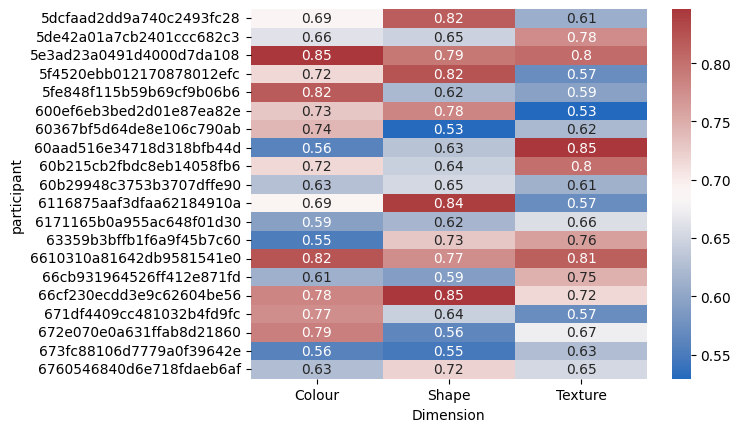

In [173]:
true_matrix_dir = "True Distance Matrices Dimensions"
euc_matrix_dir = "Euclidean Distance Matrices Dimensions"
participants = list(set([id.split("_")[0] for id in os.listdir(true_matrix_dir)]))


correlation_results = []

for id in participants:
    for dimension in ["Colour", "Texture", "Shape"]:
        true_matrix_df = pd.read_csv(f"{true_matrix_dir}/{id}_{dimension}_TrueDistMatrix.csv")
        euc_matrix_df = pd.read_csv(f"{euc_matrix_dir}/{id}_{dimension}_DistMatrix.csv")
        
        correlation_value = do_correlation(true_matrix_df, euc_matrix_df)
        correlation_results.append(
            {"participant" : id,
             "Dimension": dimension,
             "Correlation": correlation_value}
        )

correlation_results_df = pd.DataFrame(correlation_results)
pivot_table_correlation = correlation_results_df.pivot(index="participant", columns="Dimension", values="Correlation")
sns.heatmap(pivot_table_correlation, annot=True, cmap="vlag")


<p>Correlation matrices for the different speeds</p>

<Axes: xlabel='Dimension', ylabel='participant'>

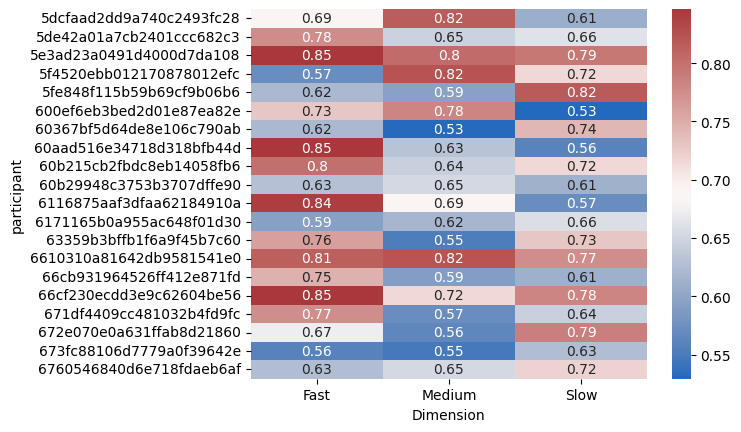

In [172]:
true_matrix_dir = "True Distance Matrices Speed"
euc_matrix_dir = "Euclidean Distance Matrices Speed"
participants = list(set([id.split("_")[0] for id in os.listdir(true_matrix_dir)]))


correlation_results = []

for id in participants:
    for dimension in ["Slow", "Medium", "Fast"]:
        true_matrix_df = pd.read_csv(f"{true_matrix_dir}/{id}_{dimension}_TrueDistMatrix.csv")
        euc_matrix_df = pd.read_csv(f"{euc_matrix_dir}/{id}_{dimension}_DistMatrix.csv")
        
        correlation_value = do_correlation(true_matrix_df, euc_matrix_df)
        correlation_results.append(
            {"participant" : id,
             "Dimension": dimension,
             "Correlation": correlation_value}
        )

correlation_results_df = pd.DataFrame(correlation_results)
correlation_results_df
pivot_table_correlation = correlation_results_df.pivot(index="participant", columns="Dimension", values="Correlation")
sns.heatmap(pivot_table_correlation, annot=True, cmap="vlag")

<h2>Plotting arrangements of stimuli for each dimension, from second block</h2>

<h3>Colour dimension</h3>

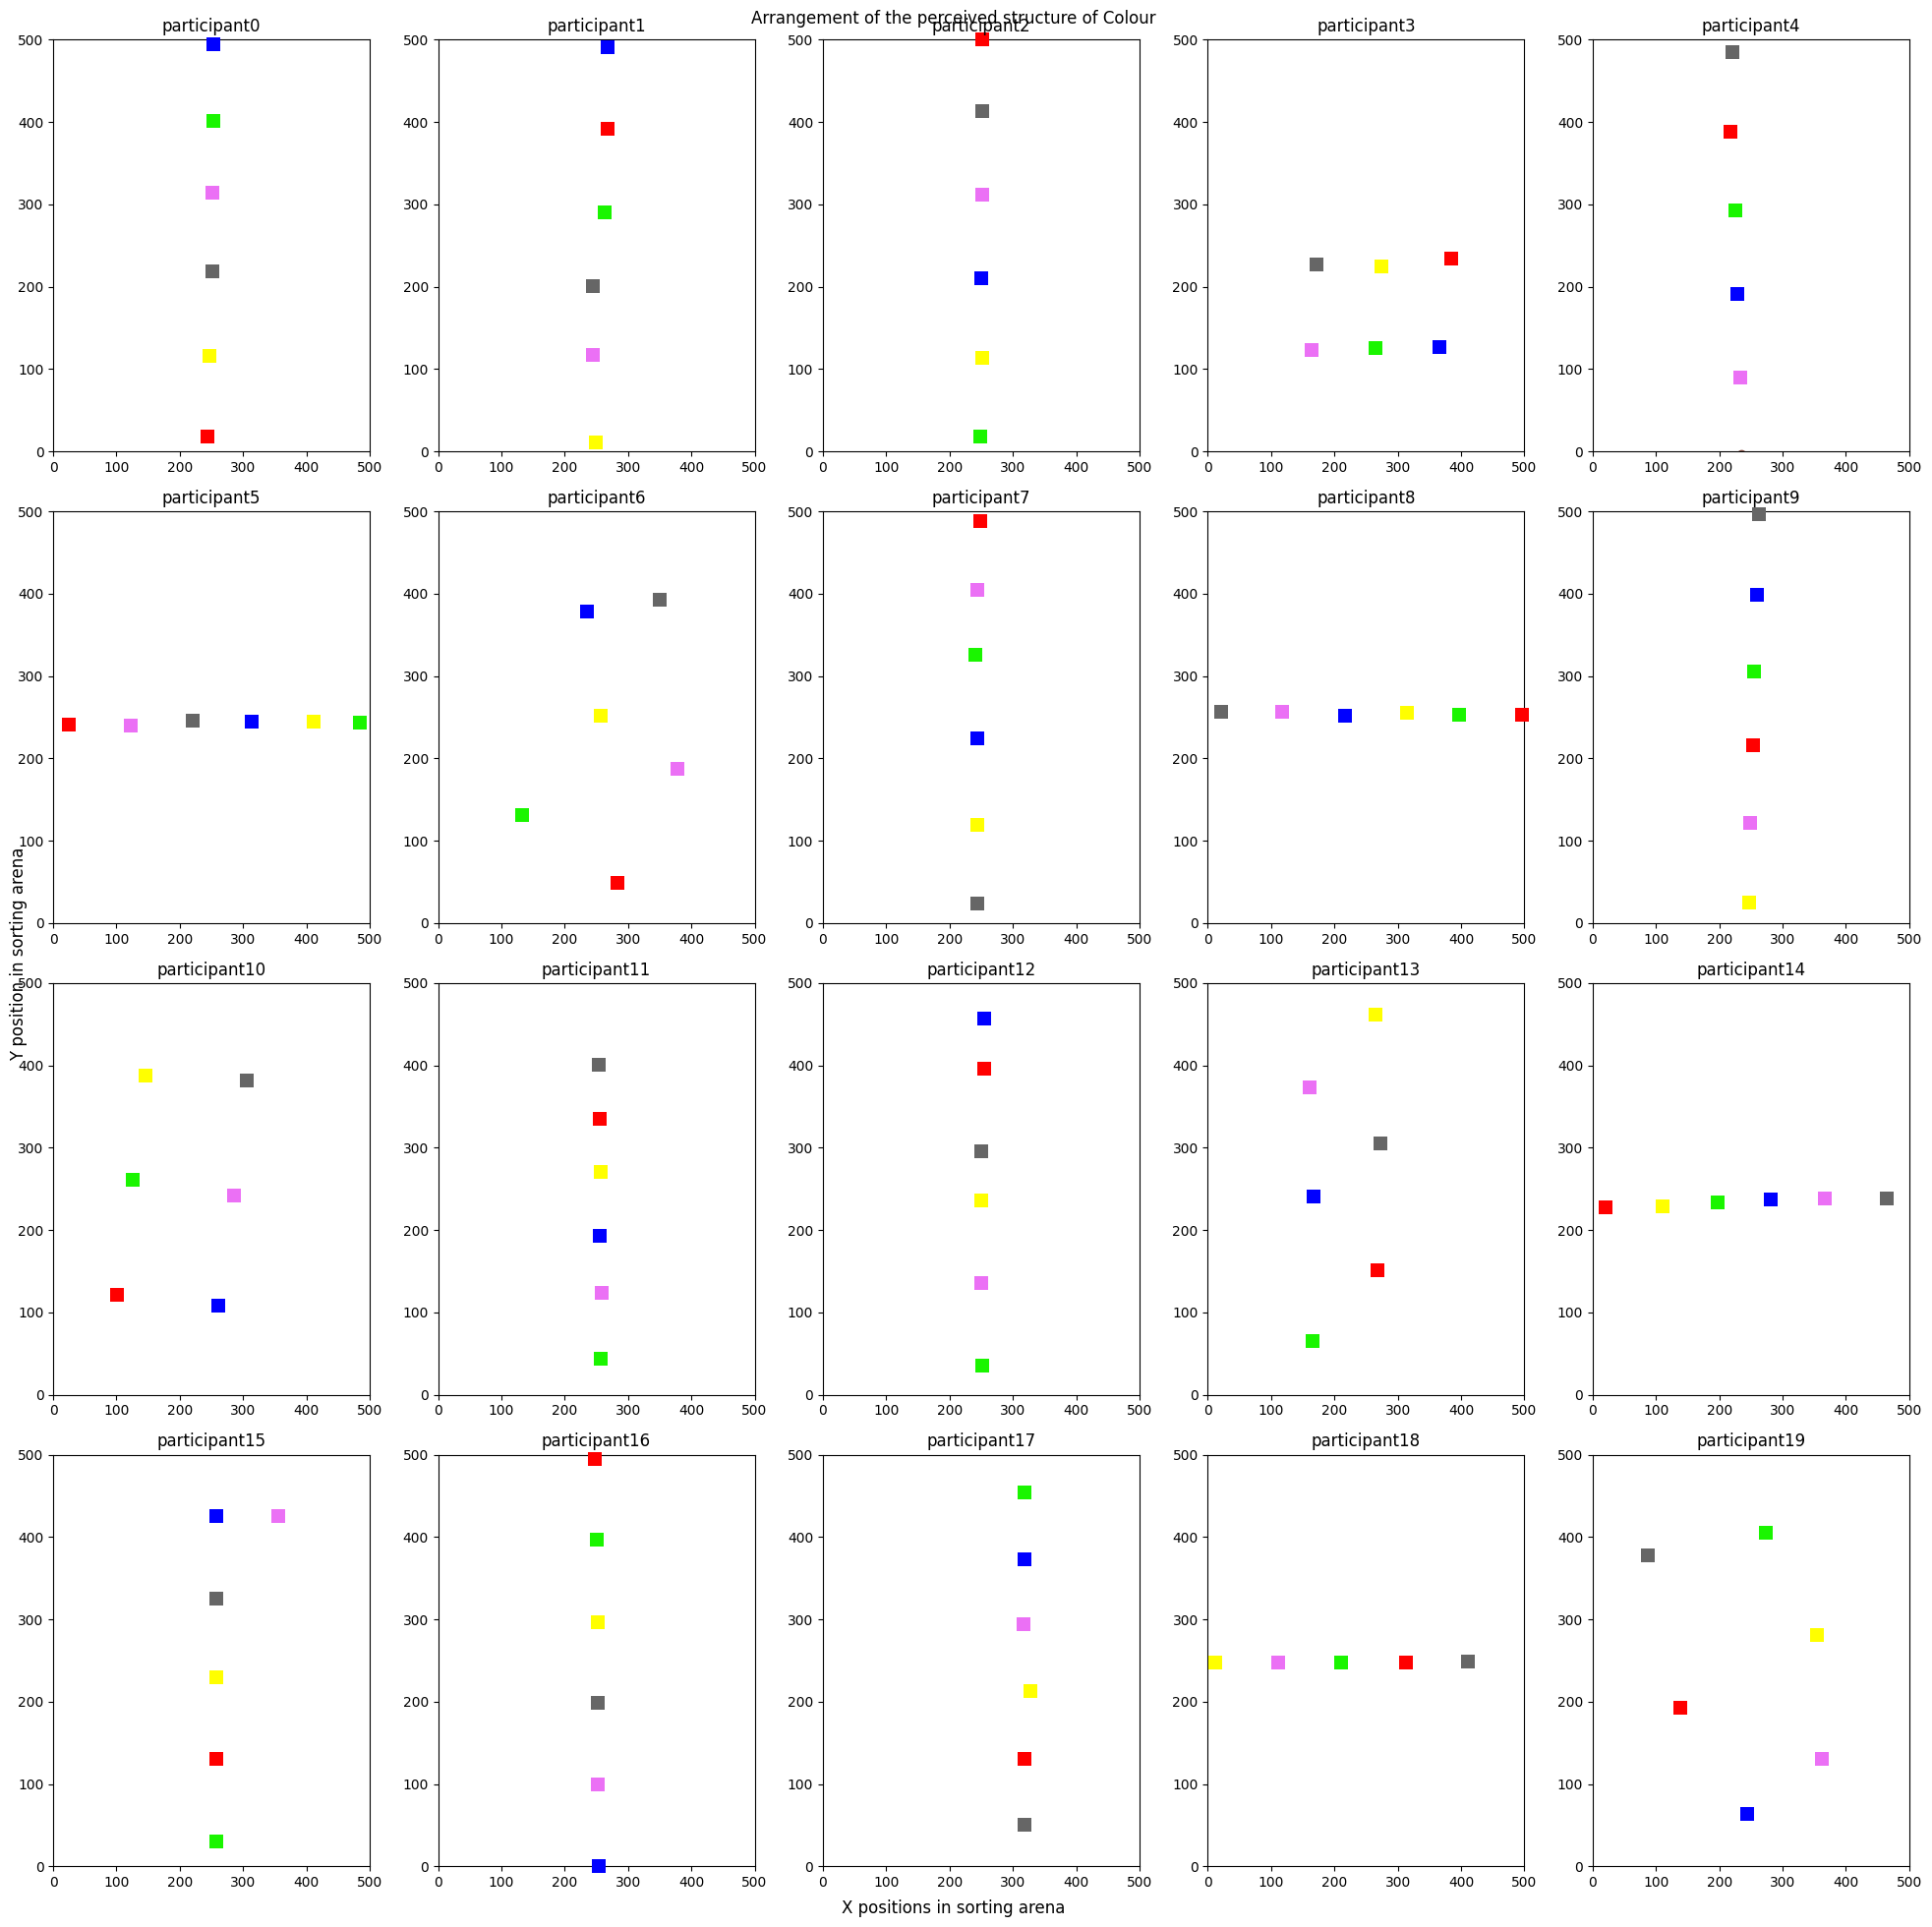

In [11]:
datasets = [file for file in os.listdir("v2_secondrun_results/Session_1 Session_2_split") if file.endswith("session_2.csv")]
cols = 5
rows = len(datasets) // cols
figsize = (20,20)
fig, axes = plt.subplots(rows, cols, figsize=figsize)
criteria_match = "Colour"



for index, participant in enumerate(datasets):
    df = pd.read_csv(f"v2_secondrun_results/Session_1 Session_2_split/{participant}")
    colstofilter = ["init_locations", "moves", "final_locations"]
    colstodrop = [col for col in df.columns if col not in colstofilter]
    sorting_block = df.loc[df["trial_type"] == "free-sort"]
    sorting_block = sorting_block.drop(colstodrop, axis=1)
    final_locations = sorting_block["final_locations"].squeeze()
    final_locations = [json.loads(i) for i in final_locations]

    plot_data = {}
    ax = axes.flatten()[index]

    #loop through all the objects and find the location data for the colours
    for obj in final_locations:
        #inner loop to grab the data, first check if it matches the criteria we need
        for data in obj:
            if criteria_match in data['src']:
                image = data['src']
                x = data['x']
                y = data['y']
                plot_data[image] = [x,y]
            else:
                continue


    #now loop through the plot data and plot them on their respective subplot
    for key in plot_data:
        image_path = key
        x_coord = plot_data[key][0]
        y_coord = plot_data[key][1]
        ax.set_title(f"participant{index}")
        ax.scatter(x_coord,y_coord)
        ax.set_xlim([0,500])
        ax.set_ylim([0,500])
        img =  Image.open(f"{image_path}")
        img.thumbnail((10,10))
        img_array = np.asarray(img)
        imagebox = OffsetImage(img_array,zoom=1)
        #this is the picture which gets overlayed on the scatter
        picture = AnnotationBbox(imagebox, (x_coord,y_coord), frameon=False)
        ax.add_artist(picture)


fig.suptitle(f"Arrangement of the perceived structure of {criteria_match}")
fig.supxlabel("X positions in sorting arena")
fig.supylabel("Y position in sorting arena")
plt.subplots_adjust(hspace=0.8)
plt.tight_layout()

    


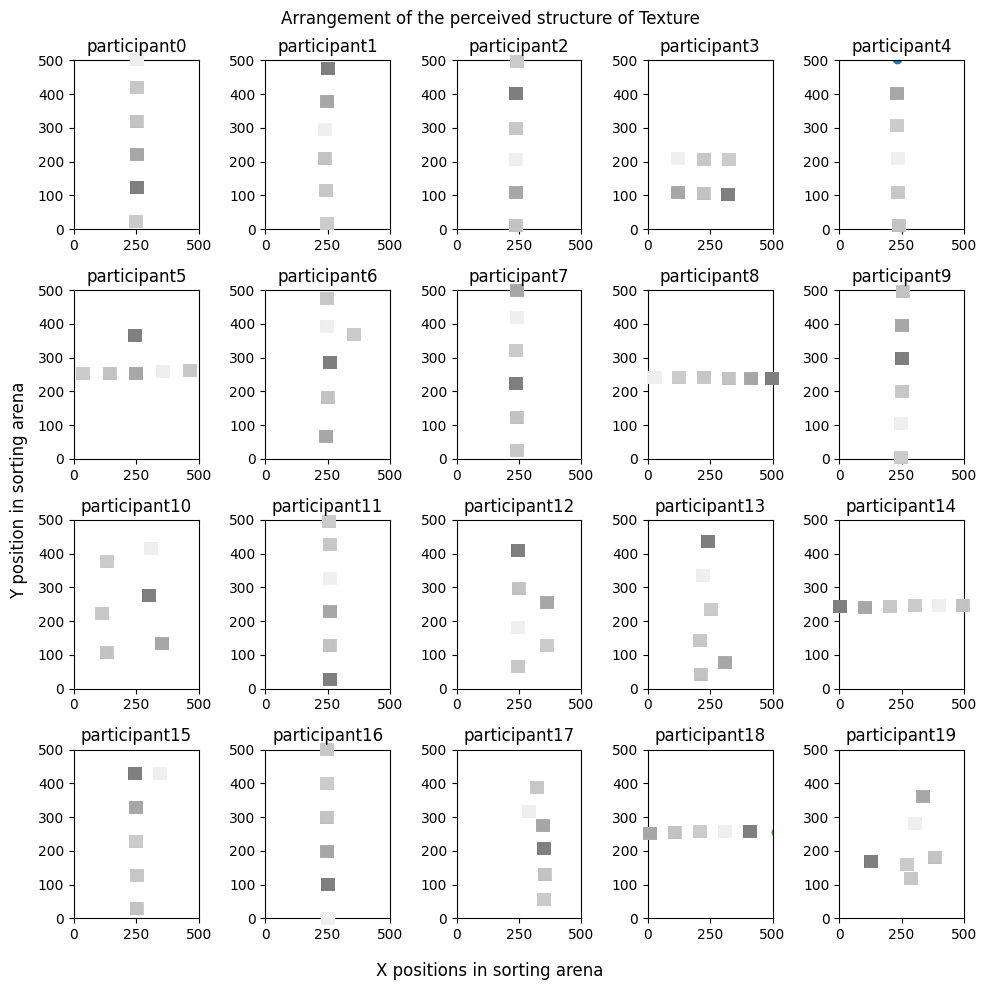

In [12]:
datasets = [file for file in os.listdir("v2_secondrun_results/Session_1 Session_2_split") if file.endswith("session_2.csv")]
cols = 5
rows = len(datasets) // cols
figsize = (10,10)
fig, axes = plt.subplots(rows, cols, figsize=figsize)
criteria_match = "Texture"



for index, participant in enumerate(datasets):
    df = pd.read_csv(f"v2_secondrun_results/Session_1 Session_2_split/{participant}")
    colstofilter = ["init_locations", "moves", "final_locations"]
    colstodrop = [col for col in df.columns if col not in colstofilter]
    sorting_block = df.loc[df["trial_type"] == "free-sort"]
    sorting_block = sorting_block.drop(colstodrop, axis=1)
    final_locations = sorting_block["final_locations"].squeeze()
    final_locations = [json.loads(i) for i in final_locations]

    plot_data = {}
    ax = axes.flatten()[index]

    #loop through all the objects and find the location data for the colours
    for obj in final_locations:
        #inner loop to grab the data, first check if it matches the criteria we need
        for data in obj:
            if criteria_match in data['src']:
                image = data['src']
                x = data['x']
                y = data['y']
                plot_data[image] = [x,y]
            else:
                continue


    #now loop through the plot data and plot them on their respective subplot
    for key in plot_data:
        image_path = key
        x_coord = plot_data[key][0]
        y_coord = plot_data[key][1]
        ax.set_title(f"participant{index}")
        ax.scatter(x_coord,y_coord)
        img =  Image.open(f"{image_path}")
        img.thumbnail((10,10))
        img_array = np.asarray(img)
        imagebox = OffsetImage(img_array,zoom=1)
        ax.set_xlim([0,500])
        ax.set_ylim([0,500])
        #this is the picture which gets overlayed on the scatter
        picture = AnnotationBbox(imagebox, (x_coord,y_coord), frameon=False)
        ax.add_artist(picture)


fig.suptitle(f"Arrangement of the perceived structure of {criteria_match}")
fig.supxlabel("X positions in sorting arena")
fig.supylabel("Y position in sorting arena")
plt.subplots_adjust(hspace=0.8)
plt.tight_layout()

    


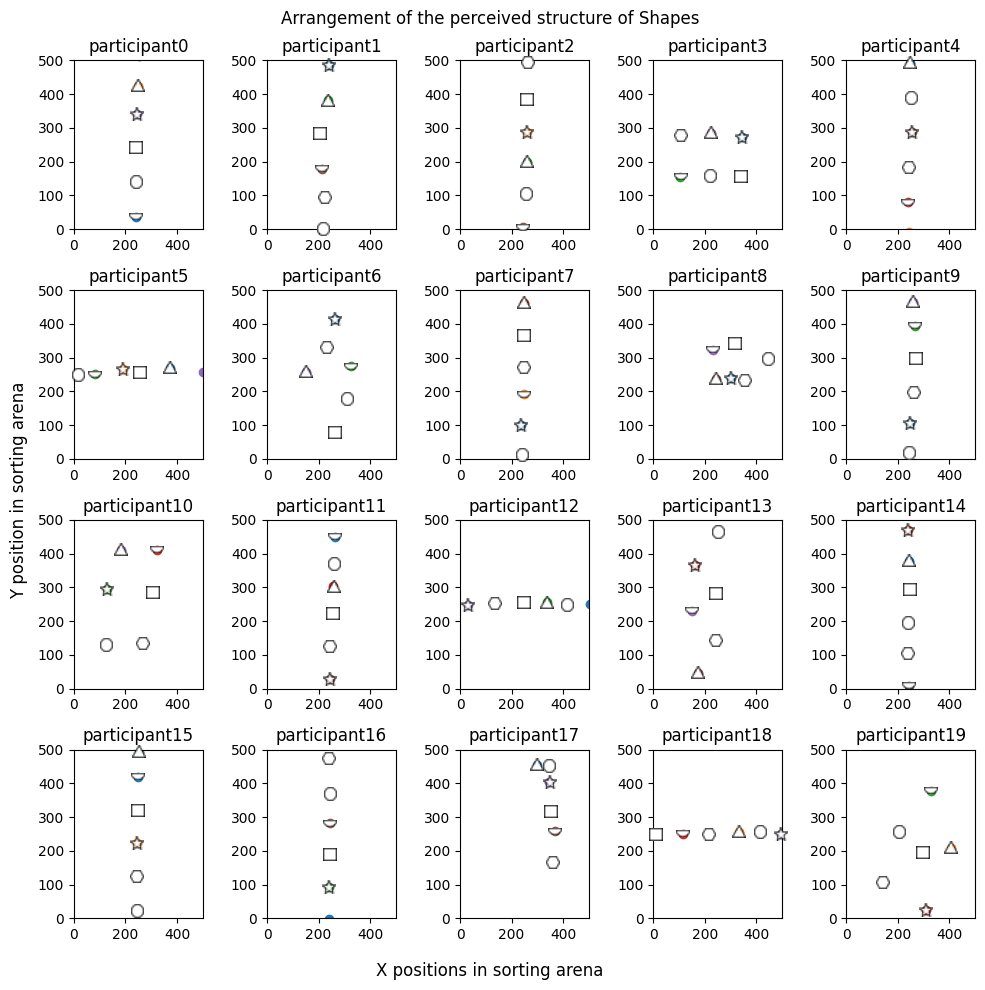

In [13]:
datasets = [file for file in os.listdir("v2_secondrun_results/Session_1 Session_2_split") if file.endswith("session_2.csv")]
cols = 5
rows = len(datasets) // cols
figsize = (10,10)
fig, axes = plt.subplots(rows, cols, figsize=figsize)
criteria_match = "Shapes"



for index, participant in enumerate(datasets):
    df = pd.read_csv(f"v2_secondrun_results/Session_1 Session_2_split/{participant}")
    colstofilter = ["init_locations", "moves", "final_locations"]
    colstodrop = [col for col in df.columns if col not in colstofilter]
    sorting_block = df.loc[df["trial_type"] == "free-sort"]
    sorting_block = sorting_block.drop(colstodrop, axis=1)
    final_locations = sorting_block["final_locations"].squeeze()
    final_locations = [json.loads(i) for i in final_locations]

    plot_data = {}
    ax = axes.flatten()[index]

    #loop through all the objects and find the location data for the colours
    for obj in final_locations:
        #inner loop to grab the data, first check if it matches the criteria we need
        for data in obj:
            if criteria_match in data['src']:
                image = data['src']
                x = data['x']
                y = data['y']
                plot_data[image] = [x,y]
            else:
                continue


    #now loop through the plot data and plot them on their respective subplot
    for key in plot_data:
        image_path = key
        x_coord = plot_data[key][0]
        y_coord = plot_data[key][1]
        ax.set_title(f"participant{index}")
        ax.scatter(x_coord,y_coord)
        img =  Image.open(f"{image_path}")
        img.thumbnail((10,10))
        img_array = np.asarray(img)
        imagebox = OffsetImage(img_array,zoom=1)
        ax.set_xlim([0,500])
        ax.set_ylim([0,500])
        #this is the picture which gets overlayed on the scatter
        picture = AnnotationBbox(imagebox, (x_coord,y_coord), frameon=False)
        ax.add_artist(picture)


fig.suptitle(f"Arrangement of the perceived structure of {criteria_match}")
fig.supxlabel("X positions in sorting arena")
fig.supylabel("Y position in sorting arena")
plt.subplots_adjust(hspace=0.8)
plt.tight_layout()

    
